# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from scipy import stats
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


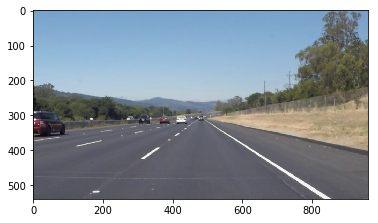

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

### draw_lines helper functions

In [3]:
def find_coordinates(img, slope, intercept, max_y):
    """
    Given slope and intercept, provides line coordinates
    """
    y1 = img.shape[0]
    x1 = int((y1 - intercept) / slope)
    y2 = max_y + 20
    x2 = int((y2 - intercept) / slope)
    return x1, x2, y1, y2
    
def print_line(img, slope, intercept, max_y):
    """
    Draw line on image given slope and intercept
    """
    color=[255, 0, 0] 
    thickness=10
    if slope and slope > 1:
        print(slope)
    if slope != None:
        x1, x2, y1, y2 = find_coordinates(img, slope, intercept, max_y)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        
def find_pos_and_neg_lines(lines):
    negative_xs = []
    positive_xs = []
    negative_ys = []
    positive_ys = []
    for idx, line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope < 0:
                negative_xs.append(x1)
                negative_xs.append(x2)
                negative_ys.append(y1)
                negative_ys.append(y2)
            else:
                positive_xs.append(x1)
                positive_xs.append(x2)
                positive_ys.append(y1)
                positive_ys.append(y2)
    
    return negative_xs, positive_xs, negative_ys, positive_ys

def get_line_coeff(xs, ys, lower_boundary_slope, upper_boundary_slope, pre_slope, pre_intercept):
    """
    This is the core function that estimates the besrt slope and intercept given a cloud of points
    """
    a = 0.1
    b = 0.9
    # linear regression of all positive and negative sloped lines
    if len(xs) != 0 and len(ys) != 0:    
        slope, intercept, _, _, _ = stats.linregress(np.asarray(xs),np.asarray(ys))
    
        # I am assuming that lane lines tend to have a certain angle
        if slope <= upper_boundary_slope and slope >= lower_boundary_slope: 
            if pre_slope:
                adjusted_slope     = a*pre_slope     + b*slope
                adjusted_intercept = a*pre_intercept + b*intercept
            else:
                adjusted_slope = slope
                adjusted_intercept = intercept
        elif pre_slope:
            adjusted_slope = pre_slope
            adjusted_intercept = pre_intercept
        else:
            adjusted_slope = None
            adjusted_intercept = None
    
    else:
        adjusted_slope = pre_slope
        adjusted_intercept = pre_intercept
        
    return adjusted_slope, adjusted_intercept

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, max_y, previous_lines_info):
    
    lines_info = None

    # find coordinates of lines, divided by positive and negative slope (left and right lane)
    negative_xs, positive_xs, negative_ys, positive_ys = find_pos_and_neg_lines(lines)
            
    # in a video stream we (might) have the informatin from the previous frame about the location of the lane lines
    pre_slope_neg = pre_intercept_neg = pre_slope_pos = pre_intercept_pos = None
    if previous_lines_info:
        pre_slope_neg, pre_intercept_neg, pre_slope_pos, pre_intercept_pos = previous_lines_info
    
    # define lower and upper bound for negative slope
    lower_boundary_slope = -0.78
    upper_boundary_slope = -0.54
    
    adjusted_slope_neg, adjusted_intercept_neg = get_line_coeff(
                    negative_xs, 
                    negative_ys,
                    lower_boundary_slope,
                    upper_boundary_slope,
                    pre_slope_neg, 
                    pre_intercept_neg
                    )
    
    print_line(img, adjusted_slope_neg, adjusted_intercept_neg, max_y)
    
    # define lower and upper bound for positive slope
    lower_boundary_slope = 0.52
    upper_boundary_slope = 0.71
    
    adjusted_slope_pos, adjusted_intercept_pos = get_line_coeff(
                    positive_xs, 
                    positive_ys,
                    lower_boundary_slope,
                    upper_boundary_slope,
                    pre_slope_pos, 
                    pre_intercept_pos
                    )
    
    print_line(img, adjusted_slope_pos, adjusted_intercept_pos, max_y)
    
    if adjusted_slope_neg and adjusted_slope_pos:
        lines_info = (adjusted_slope_neg, adjusted_intercept_neg, adjusted_slope_pos, adjusted_intercept_pos)

    return lines_info

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, max_y, previous_lines_info):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    lines_info = draw_lines(line_img, lines, max_y, previous_lines_info)
    return line_img, lines_info

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

### Non-video related helper functions:

In [5]:
import sys
def progress(count, total, suffix=''):
    bar_len = 60
    filled_len = int(round(bar_len * count / float(total)))

    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)

    sys.stdout.write('[{}] {}{} ...{}\r'.format(bar, percents, '%', suffix))
    sys.stdout.flush()

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import glob
images = glob.glob("test_images/*")

print(images)

['test_images/solidWhiteCurve.jpg', 'test_images/solidWhiteRight.jpg', 'test_images/solidYellowCurve.jpg', 'test_images/solidYellowCurve2.jpg', 'test_images/solidYellowLeft.jpg', 'test_images/whiteCarLaneSwitch.jpg']


In [7]:
# find image shape and make sure they all have the same shape
img = cv2.imread(images[0])
shape = img.shape
print(shape)
for image in images[1:]:
    img = cv2.imread(image)
    if shape != img.shape:
        raise Exception("Ops, found shape {} for image {} instead of shape {}".format(img.shape, image, shape))

(540, 960, 3)


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [8]:
max_y = 310
vertices = np.array([[(0, shape[0]), (460, max_y), (490, max_y), (shape[1], shape[0])]], dtype=np.int32)
masked_edges = region_of_interest(img, vertices)

def process_image(img, previous_lines_info=None):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    # convert to gray scale
    gray = grayscale(img)
    
    # apply gaussian blur
    kernel_size = 5
    blurred = gaussian_blur(gray, kernel_size)
    
    # Canny parameters
    low_threshold = 50
    high_threshold = 150
    edges = canny(blurred, low_threshold, high_threshold)
    
    # Mask part of the image where we are not going to find line lanes
    masked_edges = region_of_interest(edges, vertices)
    
    # Hough transform parameters
    rho = 2             # distance resolution in pixels of the Hough grid
    theta = np.pi/180     # angular resolution in radians of the Hough grid
    threshold = 20       # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 25  # minimum number of pixels making up a line
    max_line_gap = 15     # maximum gap in pixels between connectable line segments
    
    image_with_lines, lines_info = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, max_y, previous_lines_info)
    final_image = weighted_img(image_with_lines, img, α=0.8, β=1., λ=0.)

    return final_image, lines_info

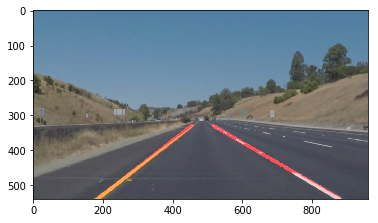

In [9]:
output_folder = 'test_images_output/'

for image in images:
    img = mpimg.imread(image)
    
    final_image, _ = process_image(img)
    
    image_name = image.split('/')[-1]
    plt.imsave('{}{}'.format(output_folder, image_name), final_image, cmap='gray')
    plt.imshow(final_image, cmap='gray')

##### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [11]:
white_input = 'test_videos/solidWhiteRight.mp4'
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip = VideoFileClip(white_input) 
count = 0
frames = []
lines_info = None
num_frames = int(clip.fps * clip.duration)
print('Processing video {}...'.format(white_output))
for idx, frame in enumerate(clip.iter_frames()):
    progress(idx+1, num_frames)
    next_frame, lines_info = process_image(frame, lines_info)
    frames.append(next_frame)
print()

print('Writing video to file {}...'.format(white_output))
import imageio
imageio.mimsave(white_output, frames, fps=clip.fps, macro_block_size=None)

Processing video test_videos_output/solidWhiteRight.mp4...
[============================================================] 100.0% ...
Writing video to file test_videos_output/solidWhiteRight.mp4...


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [13]:
yellow_input = 'test_videos/solidYellowLeft.mp4'
yellow_output = 'test_videos_output/solidYellowLeft.mp4'

clip = VideoFileClip(yellow_input) 
count = 0
frames = []
lines_info = None
num_frames = int(clip.fps * clip.duration)
print('Processing video {}...'.format(yellow_output))
for idx, frame in enumerate(clip.iter_frames()):
    progress(idx+1, num_frames)
    next_frame, lines_info = process_image(frame, lines_info)
    frames.append(next_frame)
print()
    
print('Writing video to file {}...'.format(yellow_output))
import imageio
imageio.mimsave(yellow_output, frames, fps=clip.fps, macro_block_size=None)

Processing video test_videos_output/solidYellowLeft.mp4...
[============================================================] 100.0% ...
Writing video to file test_videos_output/solidYellowLeft.mp4...


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
challenge_input = 'test_videos/challenge.mp4'
challenge_output = 'test_videos_output/challenge.mp4'

clip = VideoFileClip(challenge_input) 
count = 0
frames = []
lines_info = None
num_frames = int(clip.fps * clip.duration)
print('Processing video {}...'.format(challenge_input))
for idx, frame in enumerate(clip.iter_frames()):
    progress(idx+1, num_frames)
    frame = cv2.resize(frame ,(960, 540), interpolation = cv2.INTER_CUBIC)
    next_frame, lines_info = process_image(frame, lines_info)
    frames.append(next_frame)
print()
    
print('Writing video to file {}...'.format(challenge_output))
import imageio
imageio.mimsave(challenge_output, frames, fps=clip.fps, macro_block_size=None)

Processing video test_videos/challenge.mp4...
[============================================================] 100.4% ...
Writing video to file test_videos_output/challenge.mp4...


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))